<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/rice_proper_broken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 割米（われまい）判別アルゴリズムの作成
## ライセンス
- イネ種子データセット
    - CC-BY-NC 4.0
- 実行コード
    - CC-BY-NC 4.0
## 解説
- 精米されたコメに含まれる割れた米粒の存在は、出荷や商品価値において非常に重要な意味を持ちます。なぜならば、割れた米粒の割合は品質を低下させ、商品価値に影響を与えるからです。
- 画像解析によって、割米を迅速かつ正確に識別し、分類することを試みましょう。
- 今回は、整流米（proper）・割米（broken）の画像を用いて、基本的な画像操作のみで識別アルゴリズムを作成します。

## 実行コード

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### データセットのダウンロードと確認

In [ ]:
url = 'https://github.com/phytometrics/plant_phenotyping_python/raw/main/notebooks/assets/basics/rice_two_class_seeds.zip'
!mkdir data
!wget -O data/rice_two_class_seeds.zip {url}
!unzip -q data/rice_two_class_seeds.zip -d data
!rm data/rice_two_class_seeds.zip

### 画像を表示する

(32, 32) (32, 32)


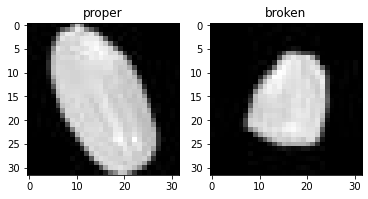

In [3]:
path1 = './data/image/train/proper/100.jpg'
path2 = './data/image/train/broken/141.jpg'
proper = cv2.imread(path1, 0)
broken = cv2.imread(path2, 0)
print(proper.shape, broken.shape)

plt.subplot(1,2,1)
plt.title("proper")
plt.imshow(proper, cmap='gray')

plt.subplot(1,2,2)
plt.title("broken")
plt.imshow(broken, cmap='gray')

plt.show()

### 読み込んだ画像の情報を確認する

In [34]:
print(type(proper))
print(proper.dtype)
print(proper.shape)
print(proper)

<class 'numpy.ndarray'>
uint8
(32, 32)
[[0 5 2 ... 0 0 0]
 [4 5 0 ... 0 0 0]
 [1 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 3 0]
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 0 3]]


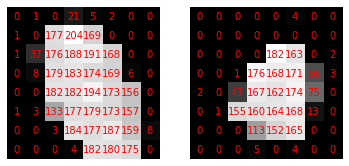

In [30]:
# 画像のピクセル値を表示する。なお、32x32では大きすぎるので、縮小して表示する

image = cv2.resize(proper, (8, 8), interpolation=cv2.INTER_NEAREST)
image2 = cv2.resize(broken, (8, 8), interpolation=cv2.INTER_NEAREST)

plt.subplot(1,2,1)
plt.imshow(image,cmap="gray")
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        text = plt.text(j, i, round(image[i, j], 2),
                        ha="center", va="center", color="red")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image2,cmap="gray")
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        text = plt.text(j, i, round(image2[i, j], 2),
                        ha="center", va="center", color="red")
plt.axis("off")

plt.show()

### 閾値を設定して、画像を二値画像変換する（フィルタリングする）

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[False False False False]
 [False False False False]
 [False  True  True  True]
 [ True  True  True  True]]
bool
8より大きい要素の数 7


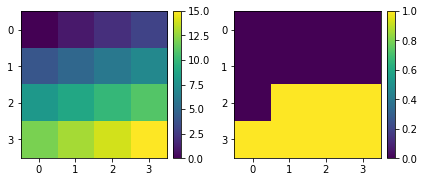

In [5]:
# 行列のフィルタリングを例に説明する
a = np.arange(16).reshape(4, 4)  # 0-15の整数値を4x4の行列に変換する
print(a)
# 8を閾値にしてフィルタリングする
b = a > 8
print(b)  # 8より大きい要素はTrue, それ以外はFalse
print(b.dtype)  # bool型
print("8より大きい要素の数", np.sum(b))  # Trueの要素数を数える

plt.subplot(1,2,1)
plt.imshow(a)
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,2,2)
plt.imshow(b)  # 画像として表示すると、Trueは黄、Falseは紫で表示される
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


面積は 489 ピクセル


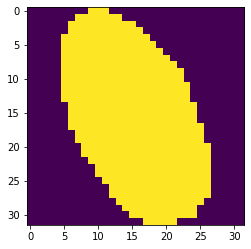

In [48]:
# 画像でも同様の操作を行う

binary = proper > 50
print("面積は", np.sum(binary), "ピクセル")
plt.imshow(binary)
plt.show()


### trainフォルダのproperとbrokenフォルダの画像からそれぞれの面積を計算し、取得する

In [52]:
def get_area(img):
    binary = img > 50
    return np.sum(binary)

areas = []
labels = []

TRAIN_DATA_DIR = "./data/image/train/"
for folder in ["proper", "broken"]:
    folder_path = os.path.join(TRAIN_DATA_DIR, folder)
    files = os.listdir(folder_path)
    for file in files:
        path = os.path.join(folder_path, file)
        img = cv2.imread(path, 0)
        # 面積の計算
        binary = img > 50
        area = np.sum(binary)
        # 面積の格納
        areas.append(area)
        # ラベルの格納
        if folder == "proper":
            labels.append(0)
        else:
            labels.append(1)

# numpyの配列に変換する
areas = np.array(areas)
labels = np.array(labels)

#最初の１０個を表示する
print(areas[:10])
print(labels[:10])
# 最後の１０個を表示する
print(areas[-10:])
print(labels[-10:])

[370 459 489 480 403 511 513 507 477 514]
[0 0 0 0 0 0 0 0 0 0]
[235 258 282 271 311 259 232 280 296 243]
[1 1 1 1 1 1 1 1 1 1]


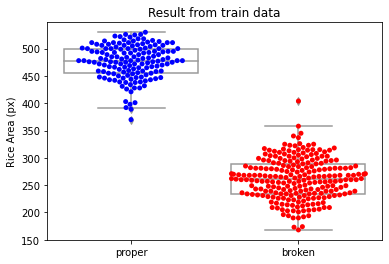

In [88]:
# 箱ひげ図とスワームプロットを表示する
sns.swarmplot(x=labels, y=areas, palette=["blue", "red"])
sns.boxplot(x=labels, y=areas, palette=["white", "white"])
plt.title("Result from train data")
plt.xticks([0,1],["proper", "broken"])
plt.ylabel("Rice Area (px)")
plt.show()

上のように整流米と割れ米の面積を図として表示すると、あらためて面積の大きさが異なることがわかります。
このことから、面積を特徴量として、整流米と割れ米を判別することができると考えられます。
とくに、閾値約350で最も効率的に整流米と割れ米を判別できることが推察されます。
ここまでの情報をもとに判別器を作成しましょう。

In [7]:
def rice_seed_classifier(img):
    binary = img > 50
    area = np.sum(binary)
    if area > 350:
        return 0
    else:
        return 1

# 正解ラベルと予測ラベルを格納するリストを作成する
y_true = []
y_pred = []

TRAIN_DATA_DIR = "./data/image/train/"
for folder in ["proper", "broken"]:
    folder_path = os.path.join(TRAIN_DATA_DIR, folder)
    files = os.listdir(folder_path)
    for file in files:
        path = os.path.join(folder_path, file)
        img = cv2.imread(path, 0)
        # 正解ラベルの格納
        if folder == "proper":
            y_true.append(0)
        else:
            y_true.append(1)
        # 予測ラベルの格納
        _y = rice_seed_classifier(img)
        y_pred.append(_y)

# numpyの配列に変換する
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 最初の１０ペアを表示する
print(y_true[:10])
print(y_pred[:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


[[146   0]
 [  2 229]]


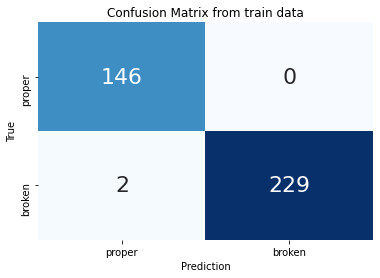

accuracy 0.9946949602122016
precision 1.0
recall 0.9913419913419913


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score

# 混同行列を表示する
cm = confusion_matrix(y_true, y_pred)
print(cm)

# 図示する
sns.heatmap(cm, annot=True, cmap="Blues",fmt="d", cbar=False,annot_kws={"fontsize":22})
plt.title("Confusion Matrix from train data")
plt.xlabel("Prediction")
plt.ylabel("True")
plt.xticks([0.5,1.5],["proper", "broken"])
plt.yticks([0.5,1.5],["proper", "broken"])
plt.show()

# ついでにaccuracyやprecision、recallも計算する。
print("accuracy", accuracy_score(y_true, y_pred))
print("precision", precision_score(y_true, y_pred))
print("recall", recall_score(y_true, y_pred))

このようにして作成した、モデルがtest dataでも同様に機能するか、同じ閾値や設定を用いて検証しましょう。

[[10  0]
 [ 0 10]]


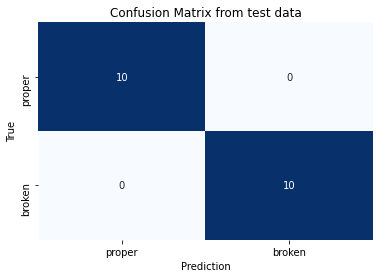

accuracy 1.0
precision 1.0
recall 1.0


In [13]:
y_true = []
y_pred = []

TEST_DATA_DIR = "./data/image/test/"
for folder in ["proper", "broken"]:
    folder_path = os.path.join(TEST_DATA_DIR, folder)
    files = os.listdir(folder_path)
    for file in files:
        path = os.path.join(folder_path, file)
        img = cv2.imread(path, 0)
        if folder == "proper":
            y_true.append(0)
        else:
            y_true.append(1)
        _y = rice_seed_classifier(img)
        y_pred.append(_y)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print(cm)

sns.heatmap(cm, annot=True, cmap="Blues",fmt="d", cbar=False)
plt.title("Confusion Matrix from test data")
plt.xlabel("Prediction")
plt.ylabel("True")
plt.xticks([0.5,1.5],["proper", "broken"])
plt.yticks([0.5,1.5],["proper", "broken"])
plt.show()

# accuracyやprecision、recallも計算する。
print("accuracy", accuracy_score(y_true, y_pred))
print("precision", precision_score(y_true, y_pred))
print("recall", recall_score(y_true, y_pred))